In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 讀取資料
df_train = pd.read_csv("./train_data.csv")
df_train.head()

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


In [3]:
df_test = pd.read_csv("./test_features.csv")
df_test.head()

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,BELDEN TIMOTHY N,5249999.0,2144013.0,-2334434.0,NaN,tim.belden@enron.com,953136.0,17355.0,484.0,228.0,...,NaN,NaN,210698.0,157569.0,NaN,213999.0,5521.0,7991.0,5501630.0,1110705.0
1,BOWEN JR RAYMOND M,1350000.0,NaN,-833.0,NaN,raymond.bowen@enron.com,NaN,65907.0,27.0,140.0,...,NaN,974293.0,1621.0,252055.0,NaN,278601.0,1593.0,1858.0,2669589.0,252055.0
2,HANNON KEVIN P,1500000.0,NaN,-3117011.0,NaN,kevin.hannon@enron.com,5538001.0,34039.0,32.0,32.0,...,NaN,1617011.0,11350.0,853064.0,NaN,243293.0,1035.0,1045.0,288682.0,6391065.0
3,DELAINEY DAVID W,3000000.0,NaN,NaN,NaN,david.delainey@enron.com,2291113.0,86174.0,3069.0,66.0,...,NaN,1294981.0,1661.0,1323148.0,NaN,365163.0,2097.0,3093.0,4747979.0,3614261.0
4,CAUSEY RICHARD A,1000000.0,NaN,-235000.0,NaN,richard.causey@enron.com,NaN,30674.0,49.0,58.0,...,NaN,350000.0,307895.0,2502063.0,NaN,415189.0,1585.0,1892.0,1868758.0,2502063.0


In [4]:
train_Y = df_train["poi"].replace([True, False], [1, 0]) #Target

# emails與姓名與目標沒有相關，另外保存以作爲結果展示
emails = df_test["email_address"]
names = df_test["name"]

# 捨棄訓練時不需要使用的欄位
df_train = df_train.drop(["email_address", "name", "poi"], axis = 1)
df_test = df_test.drop(["email_address", "name"], axis = 1)

# 結合兩組數據以作特徵處理
df = pd.concat([df_train, df_test])
df

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,NaN,19794175.0,46950.0,18.0,42.0,4.0,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,NaN,19250000.0,29336.0,108.0,88.0,30.0,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,NaN,1624396.0,22884.0,39.0,13.0,14.0,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,NaN,118134.0,NaN,NaN,NaN,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,NaN,35818.0,144.0,199.0,25.0,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,1000000.0,NaN,NaN,NaN,1465734.0,38559.0,40.0,23.0,8.0,NaN,369721.0,425688.0,378082.0,NaN,213625.0,1336.0,1607.0,2047593.0,1843816.0
29,1500000.0,NaN,NaN,NaN,1835558.0,NaN,92.0,28.0,23.0,NaN,554422.0,1852186.0,1293424.0,NaN,428780.0,2103.0,3187.0,4335388.0,3128982.0
30,NaN,504610.0,NaN,NaN,2218275.0,NaN,12.0,0.0,0.0,NaN,461912.0,NaN,NaN,NaN,NaN,23.0,169.0,966522.0,2218275.0
31,200000.0,204075.0,NaN,NaN,2549361.0,57727.0,NaN,NaN,NaN,NaN,175000.0,2630.0,514847.0,NaN,236457.0,NaN,NaN,875889.0,3064208.0


In [5]:
# 檢查DataFrame的空確值狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending = False)
    missing_data = pd.DataFrame({"Missing Ratio" : data_na})
    display(missing_data)
na_check(df)

,Missing Ratio
loan_advances,97.260274
director_fees,88.356164
restricted_stock_deferred,87.671233
deferral_payments,73.287671
deferred_income,66.438356
long_term_incentive,54.794521
bonus,43.835616
from_this_person_to_poi,41.095890
from_poi_to_this_person,41.095890
from_messages,41.095890


In [6]:
from collections import defaultdict

# 缺值用平均數填補
df["salary"] = df["salary"].fillna(df["salary"].mean())

# 缺值用中位數填補
fill_na_median = ["total_payments", "total_stock_value", "other"]

# 缺值填0
fill_na_0 = ["deferred_income", "deferral_payments", "exercised_stock_options", "restricted_stock",
            "shared_receipt_with_poi", "bonus", "expenses",
            "director_fees","long_term_incentive","restricted_stock_deferred"]

# 缺值用衆數填補
fill_na_mode = []

# 轉換為布林值
to_boolean = ["from_this_person_to_poi", "from_poi_to_this_person", "from_messages", "to_messages",
             "loan_advances"]

for col in df.columns:
    if col in fill_na_0:
        df[col] = df[col].fillna(0)
    elif col in fill_na_median:
        df[col] = df[col].fillna(df[col].median())
    elif col in fill_na_mode:
        mode_dict = defaultdict(lambda:0)

        for value in df[~df[col].isnull()][col]:
            mode_dict[value] += 1
    
        mode_get = sorted(mode_dict.items(), key=lambda kv: kv[1], reverse=True)
        df[col] = df[col].fillna(mode_get[0][0])
    elif col in to_boolean:
        df[col] = df[col].fillna(0)
        df[col] = df[col].map(lambda x : 1 if x != 0 else 0)
    
# 捨棄低相關項目
#df = df.drop("restricted_stock_deferred", axis = 1)
na_check(df)

,Missing Ratio


In [7]:
# 創建新欄位
df["has_bonus"] = df["bonus"].map(lambda x : 0 if x == 0 else 1)

import math
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

#清除Outlier
df["bonus"] = df["bonus"].map(lambda x : math.sqrt(x) * 10)
df[df["deferred_income"] == 9000000.0] = 0
df[df["restricted_stock"] == -2604490.0] = 0
df[df["restricted_stock"] == 130322299.0] = 20000000
df[df["restricted_stock_deferred"] == 20000000.0] = -20000000
df[df["total_stock_value"] == -44093.0] = 0
df[df["has_bonus"] == 11000000.0] = 1
df

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,has_bonus
0,13228.756555,0.0,-3504386.0,0.0,19794175.0,46950.0,1,1,1,0,1617011.0,174839.0,2748364.0,0.0,4.206360e+05,864.0,1,505050.0,22542539.0,1
1,23664.319132,0.0,0.0,0.0,19250000.0,29336.0,1,1,1,0,1920000.0,22122.0,6843672.0,0.0,1.111258e+06,2042.0,1,8682716.0,26093672.0,1
2,4472.135955,0.0,-4167.0,0.0,1624396.0,22884.0,1,1,1,0,0.0,1573324.0,869220.0,0.0,2.118440e+05,91.0,1,2003885.0,2493616.0,1
3,8944.271910,0.0,0.0,0.0,0.0,118134.0,0,0,0,0,602671.0,907502.0,985032.0,0.0,2.243050e+05,0.0,0,2652612.0,985032.0,1
4,11180.339887,0.0,-262500.0,0.0,0.0,35818.0,1,1,1,0,375304.0,486.0,126027.0,0.0,2.401890e+05,2188.0,1,1639297.0,126027.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,10000.000000,0.0,0.0,0.0,1465734.0,38559.0,1,1,1,0,369721.0,425688.0,378082.0,0.0,2.136250e+05,1336.0,1,2047593.0,1843816.0,1
29,12247.448714,0.0,0.0,0.0,1835558.0,0.0,1,1,1,0,554422.0,1852186.0,1293424.0,0.0,4.287800e+05,2103.0,1,4335388.0,3128982.0,1
30,0.000000,504610.0,0.0,0.0,2218275.0,0.0,1,0,0,0,461912.0,52382.0,0.0,0.0,5.621943e+05,23.0,1,966522.0,2218275.0,0
31,4472.135955,204075.0,0.0,0.0,2549361.0,57727.0,0,0,0,0,175000.0,2630.0,514847.0,0.0,2.364570e+05,0.0,0,875889.0,3064208.0,1


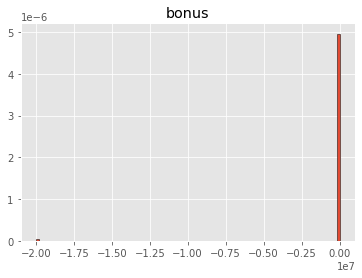

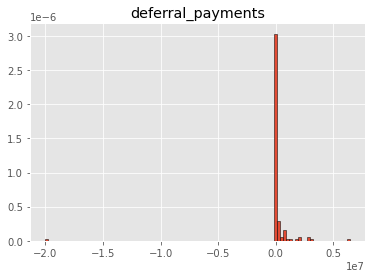

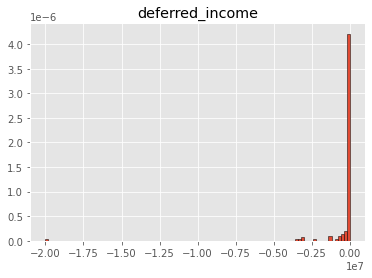

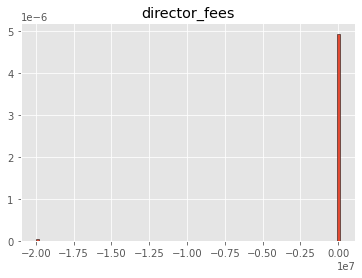

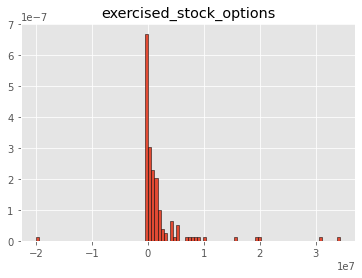

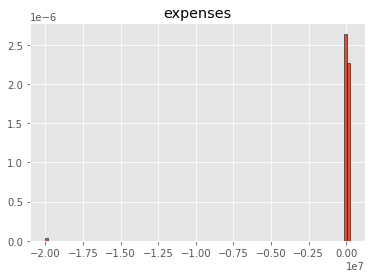

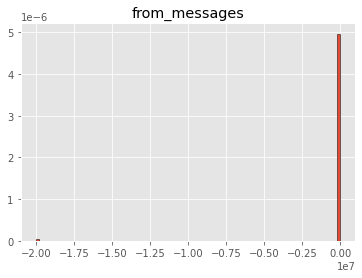

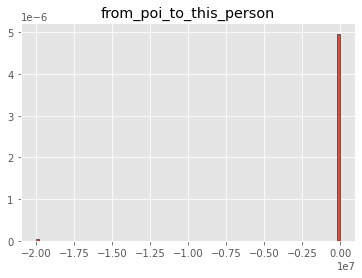

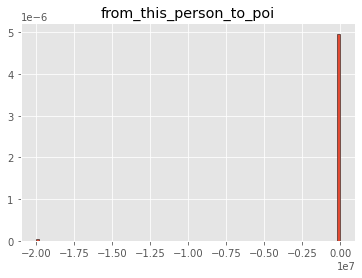

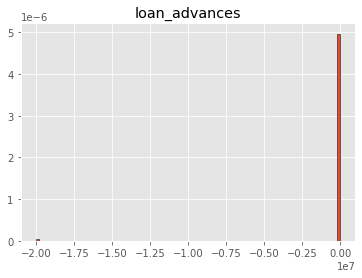

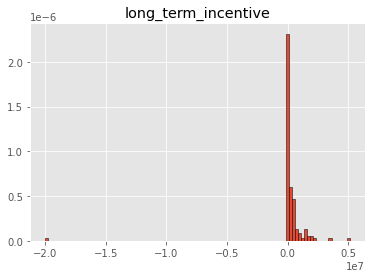

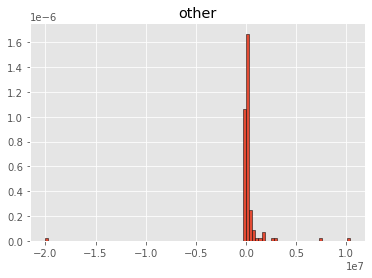

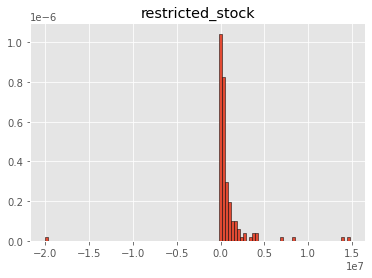

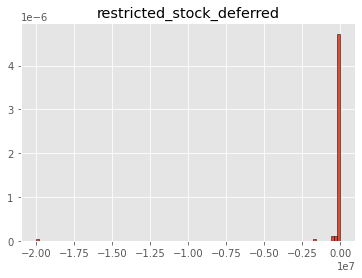

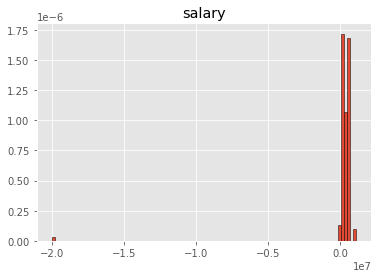

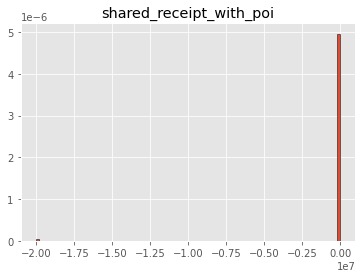

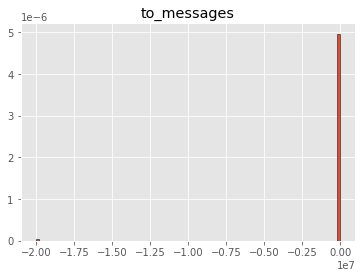

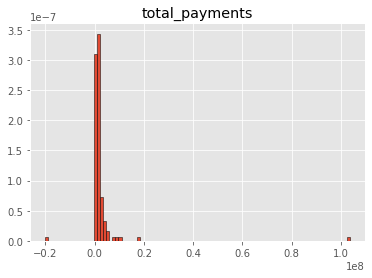

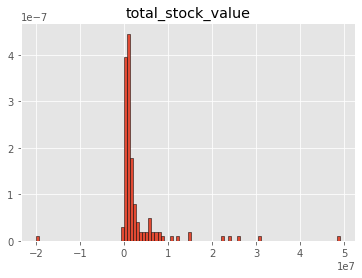

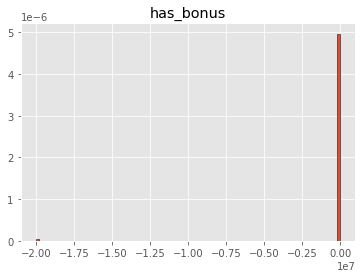

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,has_bonus
0,13228.756555,0.0,-3504386.0,0.0,19794175.0,46950.0,1,1,1,0,1617011.0,174839.0,2748364.0,0.0,4.206360e+05,864.0,1,505050.0,22542539.0,1
1,23664.319132,0.0,0.0,0.0,19250000.0,29336.0,1,1,1,0,1920000.0,22122.0,6843672.0,0.0,1.111258e+06,2042.0,1,8682716.0,26093672.0,1
2,4472.135955,0.0,-4167.0,0.0,1624396.0,22884.0,1,1,1,0,0.0,1573324.0,869220.0,0.0,2.118440e+05,91.0,1,2003885.0,2493616.0,1
3,8944.271910,0.0,0.0,0.0,0.0,118134.0,0,0,0,0,602671.0,907502.0,985032.0,0.0,2.243050e+05,0.0,0,2652612.0,985032.0,1
4,11180.339887,0.0,-262500.0,0.0,0.0,35818.0,1,1,1,0,375304.0,486.0,126027.0,0.0,2.401890e+05,2188.0,1,1639297.0,126027.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,10000.000000,0.0,0.0,0.0,1465734.0,38559.0,1,1,1,0,369721.0,425688.0,378082.0,0.0,2.136250e+05,1336.0,1,2047593.0,1843816.0,1
29,12247.448714,0.0,0.0,0.0,1835558.0,0.0,1,1,1,0,554422.0,1852186.0,1293424.0,0.0,4.287800e+05,2103.0,1,4335388.0,3128982.0,1
30,0.000000,504610.0,0.0,0.0,2218275.0,0.0,1,0,0,0,461912.0,52382.0,0.0,0.0,5.621943e+05,23.0,1,966522.0,2218275.0,0
31,4472.135955,204075.0,0.0,0.0,2549361.0,57727.0,0,0,0,0,175000.0,2630.0,514847.0,0.0,2.364570e+05,0.0,0,875889.0,3064208.0,1


In [8]:
for col in df.columns:
    df[col].hist(edgecolor = "k", bins = 100, density = True)
    plt.title(col)
    plt.show()
df

In [9]:
# 將資料最大最小化
df_col = df.columns

MMEncoder = MinMaxScaler()

# 重新分割資料
train_num = train_Y.shape[0]
train_X = MMEncoder.fit_transform(df[:train_num])
test_X = df[train_num:]

ext_data = pd.concat([train_Y, pd.DataFrame(train_X)], axis = 1)
ext_data_corr = ext_data.corr()

df_col = df_col.insert(0, "poi")
ext_data_corr = ext_data_corr.set_axis(df_col, axis = 1, inplace = False)
ext_data_corr = ext_data_corr.set_axis(df_col, axis = 0, inplace = False)
ext_data_corr

,poi,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,has_bonus
poi,1.000000,0.316386,-0.088485,-0.222006,-0.117289,0.471985,0.254843,0.085404,0.141871,0.202178,...,0.217566,0.264960,0.279710,0.084556,0.104581,0.129147,0.085404,0.276144,0.452650,0.221602
bonus,0.316386,1.000000,0.128990,-0.344960,-0.279773,0.354994,0.324205,0.387553,0.449678,0.475949,...,0.475292,0.311754,0.411148,0.050555,-0.059090,0.647390,0.387553,0.441902,0.395892,0.794065
deferral_payments,-0.088485,0.128990,1.000000,-0.429477,-0.102559,-0.001473,-0.096064,0.151575,0.119821,0.138972,...,0.059926,0.022323,-0.031827,-0.258612,-0.123921,0.019718,0.151575,0.054859,-0.021461,0.046907
deferred_income,-0.222006,-0.344960,-0.429477,1.000000,0.057564,-0.234472,-0.006452,-0.094418,-0.136808,-0.137263,...,-0.250578,-0.068955,-0.091503,0.085082,0.056482,-0.053912,-0.094418,-0.058002,-0.206948,-0.242015
director_fees,-0.117289,-0.279773,-0.102559,0.057564,1.000000,-0.126081,-0.095370,-0.368612,-0.322436,-0.274513,...,-0.152428,-0.073946,-0.138787,0.060526,0.316190,-0.200834,-0.368612,-0.076289,-0.111456,-0.352330
exercised_stock_options,0.471985,0.354994,-0.001473,-0.234472,-0.126081,1.000000,0.148277,0.020351,0.048761,0.072365,...,0.385708,0.579584,0.590515,0.031574,0.268304,0.116131,0.020351,0.604012,0.964208,0.088375
expenses,0.254843,0.324205,-0.096064,-0.006452,-0.095370,0.148277,1.000000,0.144761,0.230193,0.168484,...,0.074632,0.119622,0.183288,-0.003279,-0.115134,0.316219,0.144761,0.149171,0.175471,0.342111
from_messages,0.085404,0.387553,0.151575,-0.094418,-0.368612,0.020351,0.144761,1.000000,0.851766,0.725172,...,0.178969,0.036136,0.016148,-0.025982,-0.103287,0.530686,1.000000,0.125511,0.007188,0.391940
from_poi_to_this_person,0.141871,0.449678,0.119821,-0.136808,-0.322436,0.048761,0.230193,0.851766,1.000000,0.815463,...,0.239401,0.067402,0.062592,-0.063046,-0.149061,0.612099,0.851766,0.145611,0.044774,0.453491
from_this_person_to_poi,0.202178,0.475949,0.138972,-0.137263,-0.274513,0.072365,0.168484,0.725172,0.815463,1.000000,...,0.132731,0.038943,0.092367,0.015942,-0.135234,0.655163,0.725172,0.152347,0.074308,0.454922


In [10]:
# 檢查outlier
#five_num = [0, 25, 50, 75, 100]
#quantile_5s = [np.percentile(df[~df['bonus'].isnull()]['bonus'], q = i) for i in five_num]
#print(quantile_5s)

#df["bonus"].value_counts().sort_index(ascending = False)

# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestClassifier()
estimator.fit(train_X, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

exercised_stock_options      0.160736
total_stock_value            0.105286
bonus                        0.099557
other                        0.097070
expenses                     0.089217
total_payments               0.077589
restricted_stock             0.076048
salary                       0.061959
shared_receipt_with_poi      0.060182
deferred_income              0.059514
long_term_incentive          0.056380
deferral_payments            0.025549
from_poi_to_this_person      0.009127
has_bonus                    0.008423
from_this_person_to_poi      0.005193
from_messages                0.003771
restricted_stock_deferred    0.002667
to_messages                  0.001731
director_fees                0.000000
loan_advances                0.000000
dtype: float64

In [11]:
high_feature = list(feats[feats > 0].index)
low_feature = list(feats[feats <= 0].index)
train_X = MMEncoder.fit_transform(df[:train_num][high_feature])
test_X = test_X.drop(low_feature, axis = 1)
print("high_feature: ", high_feature, "\nlow_feature: ", low_feature)

high_feature:  ['exercised_stock_options', 'total_stock_value', 'bonus', 'other', 'expenses', 'total_payments', 'restricted_stock', 'salary', 'shared_receipt_with_poi', 'deferred_income', 'long_term_incentive', 'deferral_payments', 'from_poi_to_this_person', 'has_bonus', 'from_this_person_to_poi', 'from_messages', 'restricted_stock_deferred', 'to_messages'] 
low_feature:  ['director_fees', 'loan_advances']


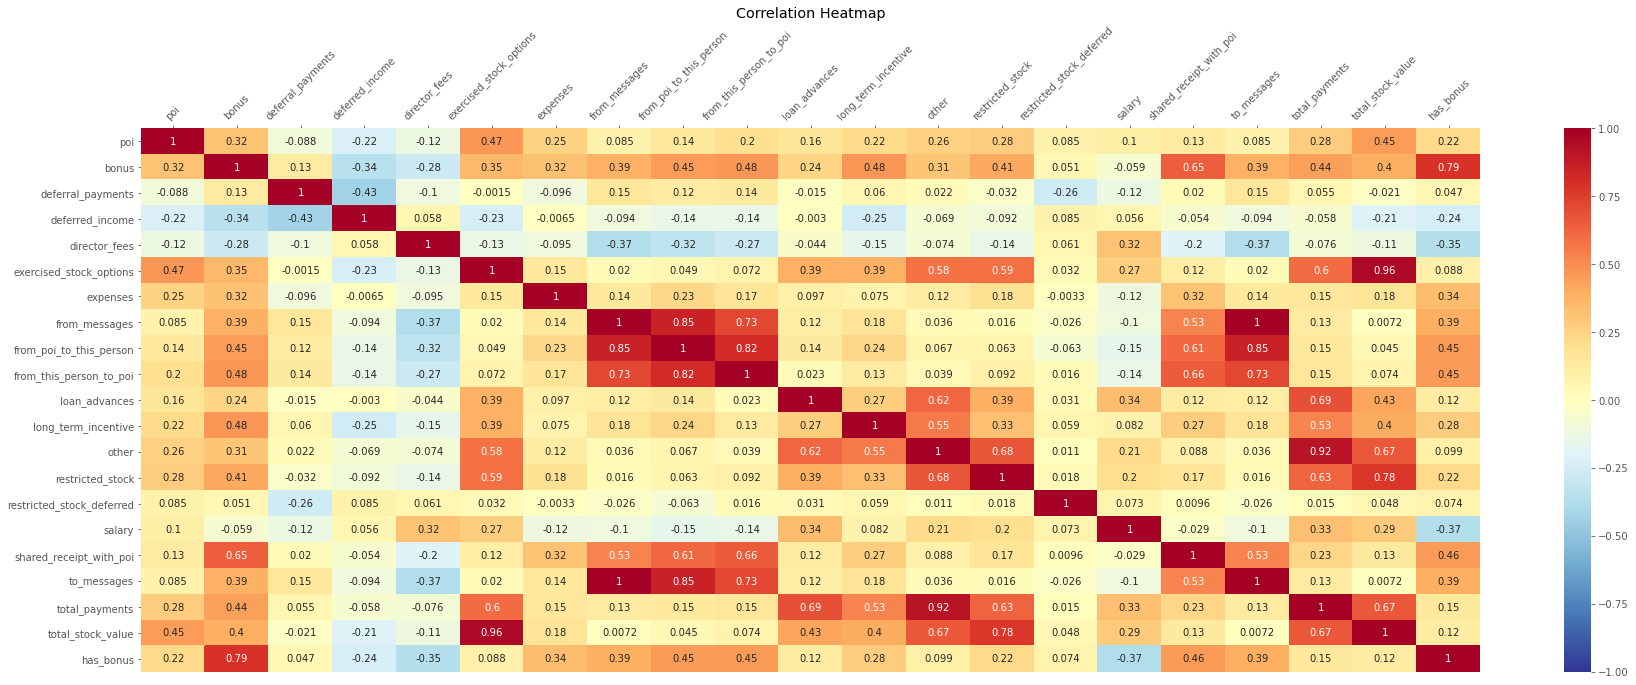

In [12]:
plt.figure(figsize = (30, 10))
heatmap = sns.heatmap(ext_data_corr, cmap = plt.cm.RdYlBu_r, vmin = -1.00, annot = True, vmax = 1.0)
heatmap.xaxis.tick_top()
plt.xticks(rotation = 45)
plt.title('Correlation Heatmap')
plt.show()

In [13]:
# 訓練模型
lr = LogisticRegression(tol=0.001, penalty='l2', fit_intercept=True, C=1.0)

gdbt = GradientBoostingClassifier()

rf = RandomForestClassifier(
    min_samples_split=2, 
    min_samples_leaf=1,
)

n_estimators = [100 * (i + 1) for i in range(10)]
max_depth = [2 * (i + 1) for i in range(10)]
print("Searching n_estimators:", n_estimators)
print("Searching max_depth:", max_depth)

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth)

grid_search = GridSearchCV(gdbt, param_grid, scoring = "neg_mean_squared_error", n_jobs = -1, verbose = 1)
gdbt_result = grid_search.fit(train_X, train_Y)                       
print(f"Best Accuracy: {gdbt_result.best_score_} using {gdbt_result.best_params_}")

grid_search = GridSearchCV(rf, param_grid, scoring = "neg_mean_squared_error", n_jobs = -1, verbose = 1)
rf_result = grid_search.fit(train_X, train_Y)                       
print(f"Best Accuracy: {rf_result.best_score_} using {rf_result.best_params_}")

gdbt = GradientBoostingClassifier(
    n_estimators = gdbt_result.best_params_["n_estimators"],
    max_depth = gdbt_result.best_params_["max_depth"],
)

rf = RandomForestClassifier(
    n_estimators = rf_result.best_params_["n_estimators"],
    max_depth = rf_result.best_params_["max_depth"],
    min_samples_split=2, 
    min_samples_leaf=1,
)

Searching n_estimators: [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
Searching max_depth: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.1s finished
Best Accuracy: -0.09762845849802372 using {'max_depth': 4, 'n_estimators': 900}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:   36.3s
Best Accuracy: -0.10632411067193677 using {'max_depth': 4, 'n_e

In [14]:
# 線性迴歸預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準, 以下模型同理)
lr.fit(train_X, train_Y)
lr_pred = lr.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': names, 'poi': lr_pred})
sub['poi'] = sub['poi'].map(lambda x:1 if x > 0.5 else 0) 
sub.to_csv('Enron_lr.csv', index=False)

In [15]:
# 梯度提升機預測檔 
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict(test_X)
sub = pd.DataFrame({'name': names, 'poi': gdbt_pred})
sub['poi'] = sub['poi'].map(lambda x:1 if x > 0.5 else 0) 
sub.to_csv('Enron_gdbt.csv', index=False)

In [16]:
# 隨機森林預測檔
rf.fit(train_X, train_Y)
rf_pred = rf.predict(test_X)
sub = pd.DataFrame({'name': names, 'poi': rf_pred})
sub['poi'] = sub['poi'].map(lambda x:1 if x > 0.5 else 0) 
sub.to_csv('Enron_rf.csv', index=False)

In [17]:
import mlxtend
from mlxtend.classifier import StackingClassifier

meta_estimator = GradientBoostingClassifier(
    n_estimators = gdbt_result.best_params_["n_estimators"],
    max_depth = gdbt_result.best_params_["max_depth"],
)

stacking = StackingClassifier(
        classifiers = [lr, gdbt, rf], 
        use_probas = True,
        average_probas=False,
        meta_classifier = meta_estimator
)

In [18]:
stacking.fit(train_X, train_Y)
stacking_pred = stacking.predict(test_X)
sub = pd.DataFrame({'name': names, 'poi': stacking_pred})
sub.to_csv('Enron_stacking.csv', index=False)